In [1]:
import pandas as pd 
import numpy as np
from numpy import asarray
from pathlib import Path
import cv2, pickle, csv, os, sys, re
from PIL import Image, ImageOps
from tools import *
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import optimizers, regularizers
from tensorflow import keras
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU

In [2]:
# Чтение таблицы ключевых точек и директории изображении. Указать путь к CSV файлу и изображениям.
csv_file_path = Path(r"C:\Training_Project300x200\Training_Project_dataset.csv")
images_dirname = Path(r"C:\Training_Project300x200\colored")

# Получения основных данных
SHAPE, last_image_index, curr_img_count, current_wd, keypoints_df, sorted_images, images_count_initail_state, csv_initial_state = get_main_data(csv_file_path, images_dirname, True)

In [ ]:
# Проверка. Просмотр заглавления таблицы
keypoints_df.head()

In [ ]:
# Просмотр одного изображения по номеру(индексу)         
plot_cow(Path(os.path.join(images_dirname, sorted_images[0])))

In [ ]:
# Просмотр изображении с аннотациями по номеру(индексу)
show_cowannot(0, keypoints_df, images_dirname, sorted_images)

In [ ]:
#                             !!! УВЕЛИЧЕНИЕ ДАННЫХ !!!

In [ ]:
# Каскад увеличения данных 
data_augment = [
    
#     FlipImages(), 
#     MirrorImages(),
#     MirrorFlipImages(),
    
#     RotateImages(5),
#     RotateImages(-5),
#     RotateImages(10),
#     RotateImages(-10),
#     RotateImages(15),
#     RotateImages(-15),
#     RotateImages(20),
#     RotateImages(-20),
#     RotateImages(30),
#     RotateImages(-30),
#     ShiftImages(10, 10),
#     ShiftImages(-10, -10),
#     ShiftImages(10, -10),
#     ShiftImages(-10, 10),   
    
#     BlurImages(5),
#     BlurImages(11),
#     NoiseImages(0.3),
#     NoiseImages(0.1),
#     ContrastImages(1.5),
#     ContrastImages(1.1),    
#     SaturationImages(1.5),
#     BrightenImages(1.5), 
#     SaturationImages(1.1),
#     BrightenImages(1.1), 

]
AugmentApply(data_augment, SHAPE, last_image_index, curr_img_count, current_wd, keypoints_df, sorted_images, images_dirname, csv_file_path, images_count_initail_state, csv_initial_state); SHAPE, last_image_index, curr_img_count, current_wd, keypoints_df, sorted_images = get_main_data(csv_file_path, images_dirname, False)

In [ ]:
# Просмотр изображении с аннотациями по номеру(индексу)
show_cowannot(0, keypoints_df, images_dirname, sorted_images)

In [ ]:
#                            !!! ЧАСТЬ МАШИННОГО ОБУЧЕНИЯ !!!

In [3]:
# Подготовка данных
if SHAPE[2] == 3:
    X = np.stack([string2image(Path(os.path.join(images_dirname, image_path))) for image_path in sorted_images]).astype(np.float64)[:, :, :, :]
if SHAPE[2] == 1:
    X = np.stack([string2image(Path(os.path.join(images_dirname, image_path))) for image_path in sorted_images]).astype(np.float64)[:, :, :, np.newaxis]

y = np.vstack(keypoints_df[keypoints_df.columns[2:]].values)
X_train = X / 255

In [4]:
# Подготовка данных
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

In [83]:
# МОДЕЛЬ МАШИННОГО ОБУЧЕНИЯ
model = Sequential()

initializer = tf.keras.initializers.GlorotUniform()
activation_function = 'relu'
dropout = 0.1
usebias = False
leaky_alpha = 0.1

filter_size = 64
kernel_size = (3, 3)
conv_strides = (1, 1)
padding = "same"

pool_strides = (2, 2)
pool_size = (2, 2)


model = Sequential()

# Входной слой
model.add(BatchNormalization(input_shape=(SHAPE)))
model.add(Conv2D(16, kernel_size, kernel_initializer='he_normal', padding=padding, use_bias=usebias, strides=conv_strides))
# model.add(Activation(activation_function))
model.add(LeakyReLU(alpha = leaky_alpha))
model.add(MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(Dropout(dropout))

# Второй слой
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size, padding=padding, use_bias=usebias, strides=conv_strides))
# model.add(Activation(activation_function))
model.add(LeakyReLU(alpha = leaky_alpha))
model.add(MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(Dropout(dropout))

# Второй слой
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size, padding=padding, use_bias=usebias, strides=conv_strides))
# model.add(Activation(activation_function))
model.add(LeakyReLU(alpha = leaky_alpha))
model.add(MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(Dropout(dropout))

# Второй слой
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size, padding=padding, use_bias=usebias, strides=conv_strides))
# model.add(Activation(activation_function))
model.add(LeakyReLU(alpha = leaky_alpha))
model.add(MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(Dropout(dropout))

# Второй слой
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size, padding=padding, use_bias=usebias, strides=conv_strides))
# model.add(Activation(activation_function))
model.add(LeakyReLU(alpha = leaky_alpha))
model.add(MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(Dropout(dropout))

# Второй слой
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size, padding=padding, use_bias=usebias, strides=conv_strides))
# model.add(Activation(activation_function))
model.add(LeakyReLU(alpha = leaky_alpha))
model.add(MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(Flatten())

# model.add(Dense(100, kernel_regularizer=regularizers.l2(0.001), activation = activation_function))

# model.add(Dense(3072, activation=activation_function))

model.add(Dense(2048, activation=activation_function))

model.add(Dense(1024, activation=activation_function))

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001), activation=activation_function))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation=activation_function))

# Восьмой слой
model.add(Dense(y.shape[1]))

In [84]:
 model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_69 (Batc (None, 200, 300, 3)       12        
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 200, 300, 16)      432       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 200, 300, 16)      0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 100, 150, 16)      0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 100, 150, 16)      0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 100, 150, 16)      64        
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 100, 150, 16)    

In [ ]:
# Проведение машинного обучения
acc = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=30, mode="auto", min_delta=0)
val_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, mode="auto", min_delta=0)
loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode="auto", min_delta=0)
val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="auto", min_delta=0)

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
epochs = 300
history = model.fit(X_train, y_train, 
                 validation_split=0.3, shuffle=True, 
                 epochs=epochs, batch_size=32, callbacks=[acc, val_acc])

Epoch 1/300
31/31 [==============================] - 39s 1s/step - loss: 12.3724 - accuracy: 0.0571 - val_loss: 0.6514 - val_accuracy: 0.1853
Epoch 2/300
31/31 [==============================] - 37s 1s/step - loss: 0.5671 - accuracy: 0.1264 - val_loss: 0.4749 - val_accuracy: 0.1853
Epoch 3/300
31/31 [==============================] - 37s 1s/step - loss: 0.4370 - accuracy: 0.1611 - val_loss: 0.3865 - val_accuracy: 0.1853
Epoch 4/300
31/31 [==============================] - 37s 1s/step - loss: 0.3613 - accuracy: 0.1050 - val_loss: 0.3354 - val_accuracy: 0.1853
Epoch 5/300
31/31 [==============================] - 37s 1s/step - loss: 0.3181 - accuracy: 0.1386 - val_loss: 0.2871 - val_accuracy: 0.1853
Epoch 6/300
31/31 [==============================] - 37s 1s/step - loss: 0.2698 - accuracy: 0.1498 - val_loss: 0.2394 - val_accuracy: 0.1853
Epoch 7/300
31/31 [==============================] - 38s 1s/step - loss: 0.2237 - accuracy: 0.1305 - val_loss: 0.1939 - val_accuracy: 0.1781
Epoch 8/300


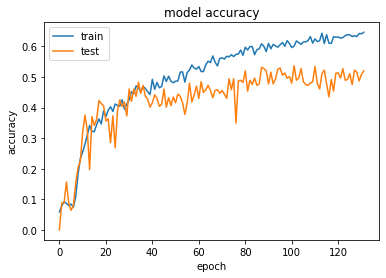

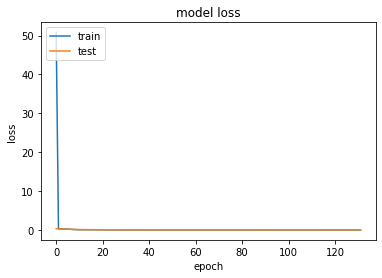

In [66]:
# Показать график изменения точности предсказании
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Показать график изменения ошибки предсказании
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

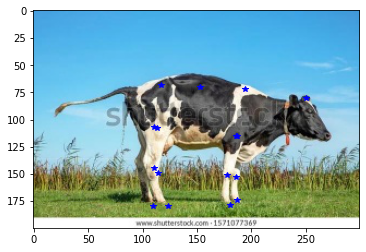

In [70]:
# Проверка предсказании. Вывод данных по номеру(индексу)
image_index = 0

# Подготовка тестовых данных
img = X_train[image_index, :, :, :].reshape(1, *SHAPE)
predictions = model.predict(img)

# Предсказание модели
xy_predictions = output_pipe.inverse_transform(predictions).reshape(y.shape[1]//2, 2)

if SHAPE[2] == 3:
    plt.imshow(X_train[image_index, :, :, :])
if SHAPE[2] == 1:
    plt.imshow(X_train[image_index, :, :, :], cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

In [80]:
# Для сохранения обученной модели
model.save('model')

# # Для загрузки ранее сохраненной модели
# model = keras.models.load_model('model')

INFO:tensorflow:Assets written to: model\assets


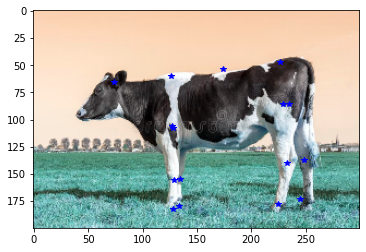

In [78]:
# Для тестирования на отдельных изображениях 

# Путь к изображению            СЮДА
test_image = cv2.imread("testdatas/test7.jpg")

reshaped_test_imageI = cv2.resize(test_image, (300, 200))
reshaped_test_image = reshaped_test_imageI.reshape(1, *SHAPE)/255
predictions = model.predict(reshaped_test_image)
xy_predictions = output_pipe.inverse_transform(predictions).reshape(y.shape[1]//2, 2)
plt.imshow(reshaped_test_imageI)
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

In [79]:
# Для тестирования на видеоизображениях + произведение записи

# Путь к видеофайлу       СЮДА
cap = cv2.VideoCapture('testdatas/cow.mp4')

if (cap.isOpened()== False): 
  print("Ошибка!")

out = cv2.VideoWriter('outputVideo.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (300, 200))

while(cap.isOpened()):
  # Чтение видео файла кадр за кадром
  ret, frame = cap.read()
  if ret == True:

    # Обработка кадров через модель МО
    reshaped_test_imageI = cv2.resize(frame, (300,200))
    reshaped_test_image = reshaped_test_imageI.reshape(1, *SHAPE)/255
    predictions = model.predict(reshaped_test_image)
    xy_predictions = output_pipe.inverse_transform(predictions).reshape(y.shape[1]//2, 2)
    for key_point in xy_predictions:
        cv2.drawMarker(reshaped_test_imageI, (int(key_point[0]), int(key_point[1])),(255,0,0), markerType=cv2.MARKER_STAR, 
        markerSize=5, thickness=2, line_type=cv2.LINE_AA)
    
    cv2.imshow('Frame', reshaped_test_imageI)
    out.write(reshaped_test_imageI)
  
    # Нажми "Q" (НА АНГЛИЙСКОЙ РАСКЛАДКЕ КЛАВИАТУРЫ!) чтоб закрыть окно воспроизведения видео
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
    
  else: 
    break

cap.release()
out.release()
cv2.destroyAllWindows()